Trial salp_local_8a-transformer_full-test: 16 points
Trial salp_local_8a-transformer_encoder-test: 16 points
Trial salp_local_8a-transformer_decoder-test: 16 points
Trial salp_local_8a-gat-test: 16 points
Trial salp_local_8a-graph_transformer-test: 16 points
Trial salp_local_8a-gcn-test: 16 points


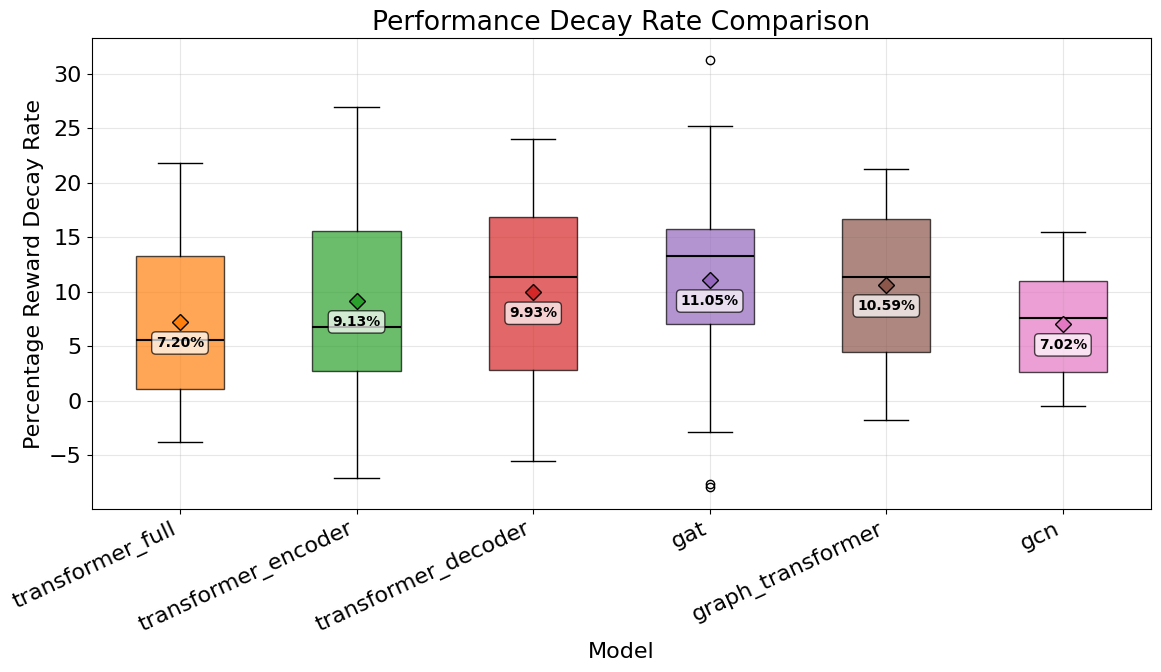

In [21]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import pickle

plt.rcParams.update({'font.size': 16})

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

data = []
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# Use a different color for each experiment-batch combination
experiment_colors = {}
color_idx = 0
decay_rates_by_exp = {}

for batch in config["batches"]:
    for experiment in config["experiments"]:

        # Use a single color for all trials of the same experiment
        exp_key = f"{batch}-{experiment}"
        if exp_key not in experiment_colors:
            experiment_colors[exp_key] = plt.cm.tab10(color_idx % 10)
            color_idx += 1
        
        for trial in config["trials"]:
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/evaluation.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)
                    print(f"Trial {exp_key}-{trial}: {len(data)} points")

                    # Extract data
                    n_agents = list(data.keys())
                    mean_rewards = np.array([np.mean(data[k]) for k in n_agents])

                    #Log difference method
                    log_means = np.log(mean_rewards)
                    decay_rates = np.diff(log_means) / np.diff(n_agents)  # Negative to show 'decay'

                    percent_decreases = (1 - mean_rewards[1:] / mean_rewards[:-1]) * 100

                    # Get consistent color
                    color = experiment_colors[exp_key]
    
                    # ax.bar(experiment, np.sum(decay_rates), width=0.5, color=color)

                    # ax.boxplot(decay_rates, vert=True, showmeans=True,patch_artist=True)
                    # Store all decay rates for this experiment
                    decay_rates_by_exp[exp_key] = percent_decreases

# Prepare box plot data and labels
boxplot_data = []
labels = []
colors = []

for exp_key, rates in decay_rates_by_exp.items():
    boxplot_data.append(rates)
    labels.append(exp_key.split('-')[1])  # Use just experiment name, not batch
    colors.append(experiment_colors[exp_key])

# Create boxplot with proper positions
bp = ax.boxplot(boxplot_data, 
                patch_artist=True,
                tick_labels=labels,
                showmeans=True)

# Customize boxplot colors
for i, box in enumerate(bp['boxes']):
    box.set(facecolor=colors[i], alpha=0.7)
    
# Set median lines to black for visibility
for median in bp['medians']:
    median.set(color='black', linewidth=1.5)

# Set mean markers to match box colors - add this part
for i, mean in enumerate(bp['means']):
    mean.set(markerfacecolor=colors[i],  # Fill color
             markeredgecolor='black',    # Border color
             marker='D',                 # Diamond shape
             markersize=8)              # Size
    
    # Calculate the mean value to annotate
    mean_value = np.mean(boxplot_data[i])
    
    # Add annotation with the mean value (formatted to 2 decimal places)
    ax.annotate(f'{mean_value:.2f}%', 
                xy=(i+1, mean_value),  # Position (i+1 because boxplot positions start at 1)
                xytext=(0, -20),        # Offset text 10 points above
                textcoords='offset points',
                ha='center',           # Horizontally center
                va='bottom',           # Place below the text
                fontsize=10,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

ax.set_xlabel("Model")
ax.set_ylabel("Percentage Reward Decay Rate")
ax.set_title("Performance Decay Rate Comparison")
ax.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=25, ha='right')
plt.tight_layout()

plt.show()